In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
import numpy as np
from model import unet,unet_backbone

In [2]:
%load_ext autoreload
%autoreload 3

In [3]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = read_voc_images(voc_dir)

In [4]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [5]:
batch_size = 32
train_iter = DataLoader(voc_train, batch_size, shuffle=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
model = unet_backbone.Unet(backbone_name='resnet50').to(device)

upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [8]:
a = torch.randn(1,3,320,480).to(device)
output = model(a)
print(output.shape)

torch.Size([1, 21, 320, 480])


In [8]:
backbone_params = []
other_params = []
for name,param in model.named_parameters():
    if name.startswith('backbone'):
        backbone_params.append(param)
    else :
        other_params.append(param)
# for name,child in model.named_children():
#     print(name)

In [9]:

def myloss(inputs,targets):
    return functional.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)


In [10]:
lr = 1e-4
# loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = myloss
# optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.Adam([{'params': backbone_params,'lr':1e-5},
                              {'params': other_params}],lr=lr)

In [11]:
torch.manual_seed(17)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 100.088142  [    0/ 1114]
loss: 88.067459  [  960/ 1114]
Test Error: 
 pixel acc: 57.92%, mean acc: 19.78%, Avg loss: 89.134082 

Epoch 2
-------------------------------
loss: 88.082542  [    0/ 1114]
loss: 81.749268  [  960/ 1114]
Test Error: 
 pixel acc: 71.25%, mean acc: 21.26%, Avg loss: 80.229135 

Epoch 3
-------------------------------
loss: 82.445061  [    0/ 1114]
loss: 80.899612  [  960/ 1114]
Test Error: 
 pixel acc: 67.88%, mean acc: 22.75%, Avg loss: 79.224537 

Epoch 4
-------------------------------
loss: 79.990425  [    0/ 1114]
loss: 78.544228  [  960/ 1114]
Test Error: 
 pixel acc: 69.02%, mean acc: 25.26%, Avg loss: 77.224478 

Epoch 5
-------------------------------
loss: 78.276810  [    0/ 1114]
loss: 75.924377  [  960/ 1114]
Test Error: 
 pixel acc: 69.90%, mean acc: 24.90%, Avg loss: 74.377407 

Epoch 6
-------------------------------
loss: 74.956299  [    0/ 1114]
loss: 73.893700  [  960/ 1114]
Test Error: 
 pixel ac

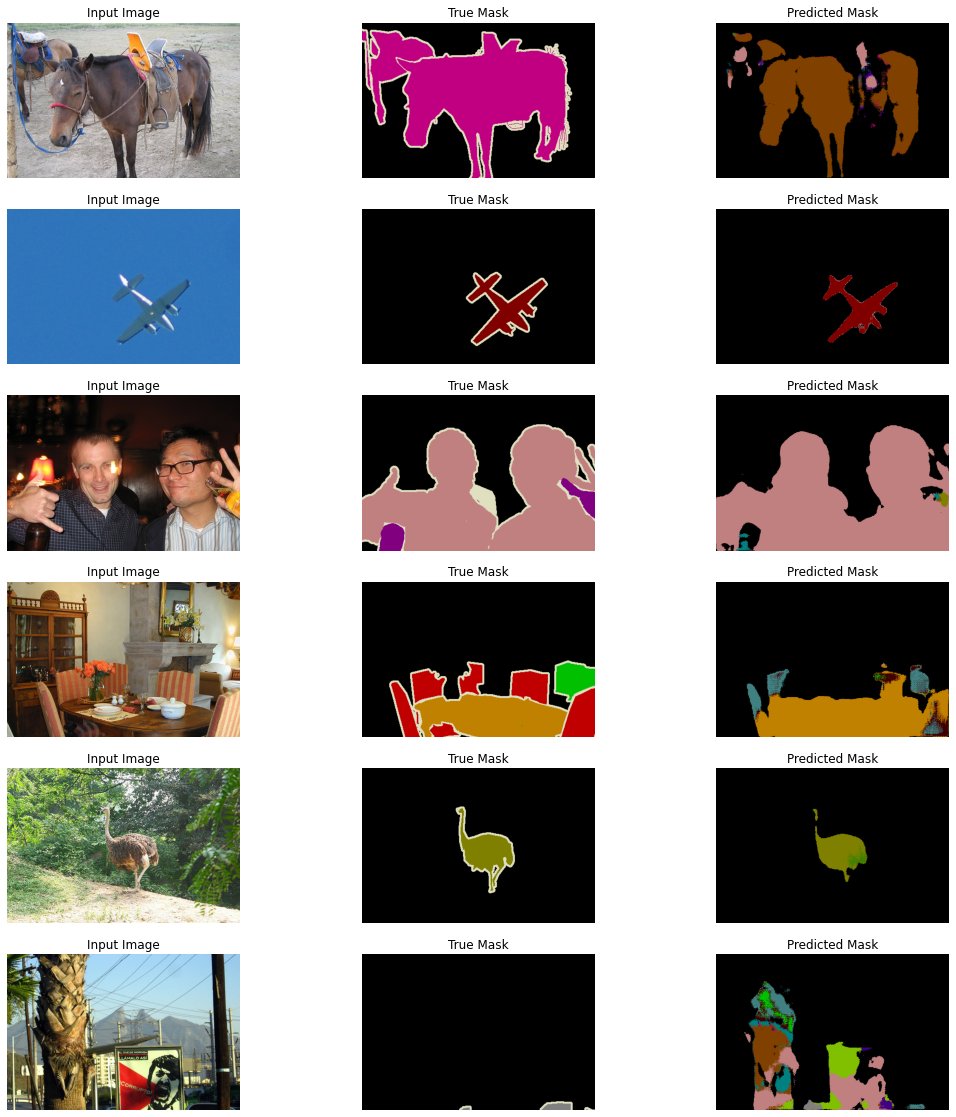

In [12]:
torch.manual_seed(17)
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [14]:
torch.save(model,'UNet-backbone-resnet50-50epochs.pt')

In [9]:
model = torch.load('UNet-backbone-resnet50-50epochs.pt',map_location=device)

In [13]:
torch.manual_seed(17)
# mean iou
model.eval()
# iou = 0
mean_iou = []
with torch.no_grad():
    for X,y in test_iter:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        pred = torch.argmax(pred,1)
        iou = utils.iou(pred,y,21,ignore_background=True)
        iou = np.mean(iou)
        mean_iou.append(iou)
        print(f'this mean iou is :{iou}')
print(f'mean iou for all is: {np.mean(mean_iou)}')

this mean iou is :0.31991313896296775
this mean iou is :0.47250338854971874
this mean iou is :0.3178939783559433
this mean iou is :0.26717969046987783
this mean iou is :0.3668171860723315
this mean iou is :0.3670969085181973
this mean iou is :0.3523639364294669
this mean iou is :0.40473663419258
this mean iou is :0.2538012868033077
this mean iou is :0.3033803835081436
this mean iou is :0.35972719744966236
this mean iou is :0.32622971659498967
this mean iou is :0.30414254781318134
this mean iou is :0.5233257204469286
this mean iou is :0.3995491304170153
this mean iou is :0.3460143868694272
this mean iou is :0.4087721569714368
this mean iou is :0.35328069860067207
this mean iou is :0.3566154574280344
this mean iou is :0.3709870214956796
this mean iou is :0.3557136346674094
this mean iou is :0.38718856506060906
this mean iou is :0.30531231222141847
this mean iou is :0.3993093959664157
this mean iou is :0.39206901561846286
this mean iou is :0.3208285094233062
this mean iou is :0.4276786791